# Mu Numerical Residuals

This notebook demonstrates residuals between the distance modulus ($\mu$) calculated by `astopy` and `sncosmo`.

In [7]:
import numpy as np
import sncosmo
from astropy.cosmology import WMAP9
from matplotlib import pyplot as plt


In [8]:
def apparent_mag_for_model(sn_model):
    """Calculate the distance modulus of a model

    Args:
        sn_model (Model): An sncosmo model

    Returns:
        mu = m_B - M_B
    """

    dilation_factor = 1 + sn_model['z']
    time_dilation_mag_offset = - 2.5 * np.log10(dilation_factor)

    b_band = sncosmo.get_bandpass('standard::b')
    rest_band = b_band.shifted(dilation_factor)

    apparent_mag = sn_model.bandmag(rest_band, 'ab', 0) - time_dilation_mag_offset
    return apparent_mag


To demonstrate the effect, we set the peak absolute brightness of a model, calculate the apparent magnitude for that model, and determine $\mu$ as the difference of those two values. 

In [9]:
model = sncosmo.Model('salt2-extended')
z_vals = np.arange(.01, 1.1, .01)
abs_mag = -19.05

apparent_mag_arr = []
for z in z_vals:
    model.set(z=z)
    model.set_source_peakabsmag(abs_mag, 'standard::b', 'AB')
    apparent_mag_arr.append(apparent_mag_for_model(model))

apparent_mag_arr = np.array(apparent_mag_arr)
mu = apparent_mag_arr - abs_mag


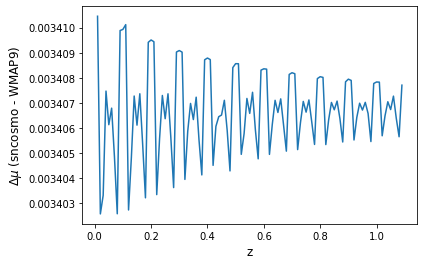

In [10]:
plt.plot(z_vals, mu - WMAP9.distmod(z_vals).value)
plt.xlabel('z', fontsize=12)
plt.ylabel(r'$\Delta\mu$ (sncosmo - WMAP9)', fontsize=12)
plt.show()


A potential source of the residuals is the interpolation process used by `sncosmo` when setting the absolute magnitude of the model. We see below that the contribution of the interpolation is too small for this to be the complete explanation.

In [11]:
def calc_abs_mag_offset(cosmo, z, abs_mb=-19.05):
    """Calculate residuals in the interpolated absolute magnitude

    Args:
        cosmo (Cosmology):
        z         (float): The redshift of the supernova model
        abs_mb    (float): The absolute B-band magnitude to set the model at

    Returns:
        The residual in magnitudes
    """
    
    source = 'salt2-extended'
    sn_model = sncosmo.Model(source)
    sn_model.set(z=z)
    sn_model.set_source_peakabsmag(abs_mb, 'standard::b', 'AB', cosmo=cosmo)
    
    return abs_mb - sn_model.source_peakabsmag('standard::b', 'AB', cosmo=cosmo)


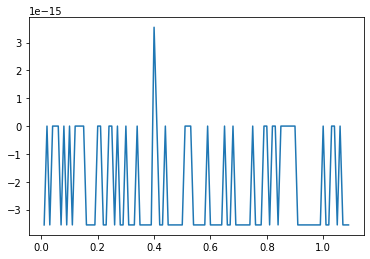

In [12]:
z_vals = np.arange(.01, 1.1, .01)
wmap_mag_offset = [calc_abs_mag_offset(WMAP9, z) for z in z_vals]
plt.plot(z_vals, wmap_mag_offset)
plt.show()
